In [1]:
import numpy as np
import pandas as pd 

from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
from matplotlib.collections import QuadMesh
from tabulate import tabulate

In [3]:
def bernoulli_conf_interval(p: float, n: int, confidence: float):
    """
    Calculates confidence interval for n i.i.d. bernoulli(p) random variables.
    It is using CLT: we approximating the average of n i.i.d. bernoulli(p) distributed random
    variables with normal distribution.

        confidence interval: p ± z * (p(1-p) / n)^(1/2)
        alpha = 1 - confidence
        z = 1 - alpha / 2 quantile for standard normal distribution


    :param p: the probability of 1 
    :param n: number of i.i.d. bernoulli(p) random variables
    :param confidence: confidence value (0 < confidence < 1)
    :return: tuple, confidence interval
    """
    alpha = 1 - confidence                       # target error rate
    z = scipy.stats.norm.ppf(1 - alpha / 2)      # 1-alpha/2 - quantile of a standard normal distribution
    se = z * np.sqrt(p * (1 - p) / n)            # standard error
    return (p - se, p + se)

In [4]:
def confusion_matrix_metrics(y_true, y_pred, labels, plot=True, figsize=(10,10), cmap=plt.cm.Reds, fsize=10):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,), binary array
      y_pred:    prediction of the data, with shape (nsamples,), binary array
      filename:  filename of figure file to save
      labels:    list of labels, first should be the name of negative values
      figsize:   the size of the figure plotted.
    """
    metrics = {}
    cm = confusion_matrix(y_true, y_pred)
    
    # true negatives (TN): we predicted N, and they don't have the disease (actual N)
    # false positives (FP): we predicted Y, but they don't have the disease (actual N)
    # false negatives (FN): we predicted N, but they do have the disease (actual Y)
    # true positives (TP): we predicted Y and they do have the disease (actual Y)
    tn, fp, fn, tp = cm.ravel()
    metrics.update({'TP': tp, 'FN': fn, 'TN': tn, 'FP': fp})
    
    # normalzing matrix - getting rates
    cm_norm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
    
    # tnr (specificity): probability that a test result will be negative when the disease is not present (tn / actual_N)
    # fpr: probability that a test result will be positive when the disease is not present (fp / actual_N)
    # fnr: probability that a test result will be negative when the disease is present (fn / actual_Y)    
    # tpr (recall): probability that a test result will be positive when the disease is present (tp / actual_Y)
    tnr, fpr, fnr, tpr = cm_norm.ravel()
    metrics.update({'TPR': tpr, 'FNR': fnr, 'TNR': tnr, 'FPR': fpr})
    
    # ppv (precision): probability that the disease is present when the test is positive (tp / (tp + fp))
    # npv: probability that the disease is not present when the test is  negative (tn / (tn + fn))
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    ppv_conf_interval = bernoulli_conf_interval(ppv, tp + fn, 0.95)
    npv_conf_interval = bernoulli_conf_interval(npv, tn + fn, 0.95)
    metrics.update({'PPV': ppv, 'NPV': npv, 'PPV 95% CI': ppv_conf_interval, 'NPV 95% CI': npv_conf_interval})
    
    # Overall, how often is the classifier correct?
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    metrics.update({'accuracy': accuracy})

    # The weighted average of recall and precision.
    f_score = 2 * tpr * ppv / (tpr + ppv)
    metrics.update({'f_score': f_score})
    
    if plot:
        # annotation for heatmap
        annot = np.empty_like(cm_norm).astype(str)
        annot[0, 0] = 'TN={} \n\nTNR={:.2f}% \n\nNPV={:.2f}%'.format(tn, tnr * 100, npv * 100)
        annot[0, 1] = 'FP={} \n\nFPR={:.2f}%'.format(fp, fpr * 100)
        annot[1, 0] = 'FN={} \n\nFNR={:.2f}%'.format(fn, fnr * 100)
        annot[1, 1] = 'TP={} \n\nTPR={:.2f}% \n\nPPV={:.2f}%'.format(tp, tpr * 100, ppv * 100)

        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(pd.DataFrame(cm_norm, index=labels, columns=labels),
                         annot=annot, annot_kws={"size": fsize, 'color': 'w', 'fontstyle':'oblique'}, linewidths=0.1, ax=ax,
                            cbar=False, cmap=cmap, linecolor='w', fmt='')

        # face colors list
        quadmesh = ax.findobj(QuadMesh)[0]
        facecolors = quadmesh.get_facecolors()
        
        facecolors[0] = [0.35, 0.8, 0.55, 1.0]  # green
        facecolors[3] = [0.35, 0.8, 0.55, 1.0]  # green
        facecolors[1] = [0.65, 0.1, 0.1, 1.0]  # red
        facecolors[2] = [0.65, 0.1, 0.1, 1.0]  # red
        
        # set ticklabels rotation
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=12)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=25, fontsize=12)

        # set labels
        ax.axes.set_title("Accuracy={:.2f}% \n f_score={:.2f}".format(accuracy * 100, f_score), fontsize=fsize)
        ax.set_xlabel("Predicted label",fontsize=15)
        ax.set_ylabel("Actual label", fontsize=15)
        plt.tight_layout()
        plt.show()
        
        
    return metrics

In [2]:
y_true = np.array([True, True, False, False, False, False, False, True, True, False, False, False])
y_pred = np.array([False, True, False, True, True, False, False, True, False, True, False, False])

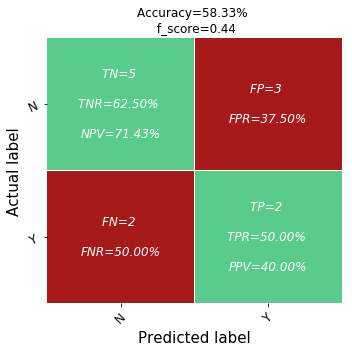

In [8]:
a = confusion_matrix_metrics(y_true, y_pred, ['N', 'Y'], cmap=None, figsize=(5, 5), fsize=12)

In [6]:
a

{'TP': 2,
 'FN': 2,
 'TN': 5,
 'FP': 3,
 'TPR': 0.5,
 'FNR': 0.5,
 'TNR': 0.625,
 'FPR': 0.375,
 'PPV': 0.4,
 'NPV': 0.7142857142857143,
 'PPV 95% CI': (-0.08009116763553092, 0.880091167635531),
 'NPV 95% CI': (0.37962785320181347, 1.048943575369615),
 'accuracy': 0.5833333333333334,
 'f_score': 0.4444444444444445}